In [1]:
import os
from matplotlib.pyplot import *
from numpy import *
import sys

try: 
    sys.path.remove('/home/adun6414/JModelica/v2_0/JModelica/Python')
    sys.path.append('/home/adun6414/Downloads/PyFMI')
except:
    print(sys.path)
    
import pyfmi

current_folder=os.getcwd()

for ls in sys.path:
    if current_folder+'/' in ls:
        sys.path.remove(ls)
os.listdir(os.getcwd())

datafolder=current_folder+'/data/'
sys.path.append(current_folder+'/src/')

# MPC Setup
- 3 day simulation period
- 10 min sampling time for MPC-Comfort
## load weather forecast (assumed perfect forecast, saved from the simulation model)

In [2]:
dt=10*60; # 10 min sampling time
Ndata= 2*24*int(3600*1./dt)# 2 days data
Tref=0 # reference temperature

start_time=6*30*24*3600.
simend_time=start_time+(Ndata-1)*dt # simulation end time to get weather data 
T=start_time+np.linspace(0,Ndata-1,Ndata)*dt 

testend_time=start_time+Ndata/2.*dt # end time for MPC & conven PI control

# ==============================================================================
# Obtain weather & gain forecast for MPC algorithm test ==============================

import numpy as np
import scipy.io
import scipy.interpolate

WF=scipy.io.loadmat(os.path.join(datafolder,'WeatherForecast'))
WInterpFun=scipy.interpolate.interp1d(squeeze(WF['time [sec]']), 
                                      np.vstack((WF['Toa [K]']-273.15-Tref,WF['qinc [kW/m2]'],WF['Qgain [kW]'])))



## load system identification data

In [3]:
from H_utility_ import *
from H_blkdiag import H_blkdiag

thetaPMV=scipy.io.loadmat(os.path.join(datafolder,'PMVfit'))['theta']
MOD=sp.io.loadmat(os.path.join(datafolder,'EvelopeModel_2'))
# %% multiple person
Nperson=2
from CVX_PMV_py3_ import CVX_PMV
Np= 6*6
NpUMPC=Np
Pmat0=np.array([1]) # unit power per unit cooling capacity, i.e. the inverse of COP
lb0=np.array([0])  # cooling capacity lower bound [0]
ub0=np.array([20]) # cooling capacity upper bound [kW]
UMPC=CVX_PMV(MOD['A'],MOD['B'],MOD['C'],MOD['K'],Np,Np,Pmat0,lb0,ub0,thetaPMV,comfmetric='mean')

# Perform MPC Simulation
## initialization & load fmu 

In [4]:
yk=mat(vstack((20,kron(ones((Nperson,1)),-thetaPMV[0]))))

t_MPC=[]
Tz_MPC=[]
PMV_MPC1=[]
PMV_MPC2=[]
Q_MPC=[]
R_MPC=[]
Toa_MPC=[]
qGh_MPC=[]
qConv_Wpm2_MPC=[]
qRad_Wpm2_MPC=[]
Pc_MPC=[]
SPc_MPC=[]

import scipy.linalg

myfmu=os.path.join(datafolder,'H_modelica_lib_HCJR_Case600FF_io_thickmass_MPC_PMV_multipeople.fmu')
fmuinpy=pyfmi.load_fmu(myfmu)
_sim_opts=fmuinpy.simulate_options()
_sim_opts['result_handling']='memory'

Could not find GLIMDA.


Final Run Statistics: --- 

 Number of steps                                 : 521
 Number of function evaluations                  : 525
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 524
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 522

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 2.931

SP: [[21.28789591]] vu: [-6.4645263e-15] vl: [-5.32787083e-15]
Final Run Statistics: --- 

 Number of steps                                 : 506
 Number of function evaluations                  : 507
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 506
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 507

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

-----------------------------------------------------
Q: 0.0 Tz: 20.174325349252 PMV1: -2.8962866087937473 PMV2: -3.0
-----------------------------------------------------
obj is : mean
SP: [[20.85052727]] vu: [-4.02660758e-14] vl: [-1.12010794e-13]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 

SP: [[20.14746312]] vu: [-3.11385068e-13] vl: [-3.58951414e-13]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[19.32695907]] vu: [-1.72577125e-14] vl: [-3.96680768e-14]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[18.52176659]] vu: [-1.10821058e-12] vl: [1.03437231e-12]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[18.96185434]] vu: [2.32339116e-11] vl: [-2.48186968e-11]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[20.82520699]] vu: [-2.15499396e-09] vl: [0.95641242]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-06
 3

SP: [[23.73236447]] vu: [-3.87935264e-09] vl: [0.98554958]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-06
 3

SP: [[27.08011985]] vu: [-4.32845833e-13] vl: [-5.4980207e-13]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.19623243]] vu: [-3.45035165e-12] vl: [-3.33561683e-12]
Final Run Statistics: --- 

 Number of steps                                 : 510
 Number of function evaluations                  : 511
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 510
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 511

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[27.42226728]] vu: [-1.17757392e-12] vl: [-8.50890422e-13]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[27.62287163]] vu: [-1.07713545e-12] vl: [-3.64647549e-13]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[27.73776943]] vu: [9.84976062e-13] vl: [-1.42171291e-12]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.80050978]] vu: [2.10994751e-13] vl: [-1.24831628e-12]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.84911641]] vu: [1.48141932e-14] vl: [-1.35198862e-13]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.82874343]] vu: [1.29184511e-14] vl: [-1.76604986e-12]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.73924906]] vu: [-8.0327278e-14] vl: [-1.18035745e-12]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[27.76140168]] vu: [7.95647712e-14] vl: [-1.74158934e-13]
Final Run Statistics: --- 

 Number of steps                                 : 509
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 510

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[28.2298493]] vu: [-8.69758971e-15] vl: [-8.61800675e-15]
Final Run Statistics: --- 

 Number of steps                                 : 508
 Number of function evaluations                  : 510
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 509
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 509

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[28.97971362]] vu: [-7.90499603e-15] vl: [-6.80244892e-15]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[28.02368518]] vu: [-1.12800845e-14] vl: [-1.39795769e-14]
Final Run Statistics: --- 

 Number of steps                                 : 507
 Number of function evaluations                  : 508
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 507
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 508

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-

SP: [[27.0840046]] vu: [-2.28685365e-14] vl: [-3.34807491e-14]
Final Run Statistics: --- 

 Number of steps                                 : 515
 Number of function evaluations                  : 520
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 1
 Number of nonlinear iterations                  : 519
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 516

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

SP: [[26.19386593]] vu: [-4.1313485e-16] vl: [-1.41885632e-15]
Final Run Statistics: --- 

 Number of steps                                 : 512
 Number of function evaluations                  : 514
 Number of Jacobian evaluations                  : 9
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 0
 Number of nonlinear iterations                  : 513
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 513

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.0000e-06 2.9315e-06 2.9315e-06 2.9315e-06 3.0000e-0

Text(0.5, 0, 'Hour')

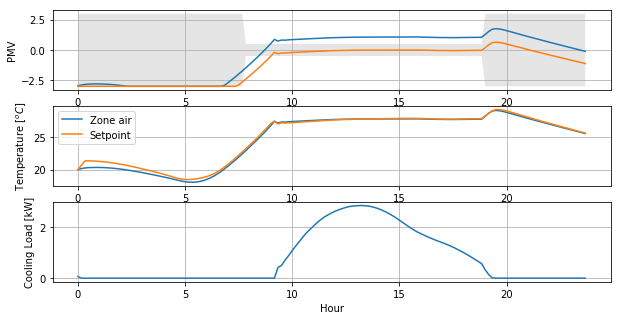

In [5]:
for k in range(1,int((testend_time-start_time)/dt)):
    #%measurement update    
    cur_t=start_time+(k-1)*dt
    
    if k>1:
        # CURRENT (see Kalman filter equ) data sampling and shift & scaling
        wk=np.mat(WInterpFun(cur_t)).T # already scaled and shifted
        yk[0]=Tz_MPC[-1]-Tref-273.15
        yk[1]=max(min(PMV_MPC1[-1],3),-3)-(thetaPMV[0]+(thetaPMV[1]+thetaPMV[2])*Tref)[0]
        yk[2]=max(min(PMV_MPC2[-1],3),-3)-(thetaPMV[0]+(thetaPMV[1]+thetaPMV[2])*Tref)[0]
        uk=-np.trapz(res['Q'],res['time'])/(res['time'][-1]-res['time'][0])/1000.
        UMPC.Kestim(yk,uk,wk) # model is defined with a 15 min sampling time
 
    # control update            
    if k==1:
        uk=np.mat([0]) # cooling
        ySPk=np.mat(20)
    elif k>1:
        pre_t=cur_t+np.linspace(1,NpUMPC,NpUMPC)*dt
        Rs     =np.mat(ones((UMPC.Np,1))) # utility cost rate $/kWh
        Ws     =np.mat(WInterpFun(pre_t)).T

        CLs=mat(H_schedule(pre_t.T,[8,19],-0.5,-3))-thetaPMV[0]
        CUs=mat(H_schedule(pre_t,[8,19],0.5,3))-thetaPMV[0]
        
        (ySPk,uk,flagUMPC)=UMPC.UMPC(yk,CLs,CUs,Ws,Rs)   
    
#    if uk[0,0]/(6.*1e3)>=0.1: # scaled cooling cap is higher than 10%
#        SPc=c2k(ySPk) # set the cooling setpoint as it is but bounded 
#        SPh=SPc-10
#    else: # floating, set the cooiling setpoint very high and the heating setpoint very low
#        SPc=30+273.15+Tref
#        SPh=10+273.15+Tref
    SPc=c2k(ySPk)
    SPh=SPc-10
    
    # system response to control
    if k > 1:
        _sim_opts['initialize'] = False
    
    tt=np.linspace((k-1)*dt,k*dt,2)
    Pert1=H_schedule(np.mat(cur_t),[11,24],0.7,0.7)
    Pert2=H_schedule(np.mat(cur_t),[11,24],0.3,0.3)
    
    # Trousers, long-sleeve shirt, 0.61
    # Trousers, long-sleeve shirt, suit jacket, 0.96
    spspPert=np.kron(np.vstack((np.array(SPc),np.array(SPh),np.array(Pert1),np.array(Pert2))),np.array([1.,1.]))
    In=(['SPc','SPh','Pert[1]','Pert[2]'],np.vstack((tt,spspPert)).T)
    res=fmuinpy.simulate(start_time=cur_t,final_time=cur_t+dt,options = _sim_opts, input=In)
    
    # Store response data at each the sampling time
    t_MPC.append(res['time'][-1])
    Tz_MPC.append(res['y'][-1])
    PMV_MPC1.append(res['PMV[1]'][-1])
    PMV_MPC2.append(res['PMV[2]'][-1])
    Q_MPC.append(res['Q'][-1])
    R_MPC.append(res['SC.R'][-1])
    Pc_MPC.append(res['Pc'][-1])
    SPc_MPC.append(SPc-273.15)
    
    
    Toa_MPC.append(res['weaBus.TDryBul'][-1])
    qGh_MPC.append(res['weaBus.HGloHor'][-1])
    qConv_Wpm2_MPC.append(res['qConGai_flow.y'][-1])
    qRad_Wpm2_MPC.append(res['qRadGai_flow.y'][-1])
    print('-----------------------------------------------------')
    print('Q:', Q_MPC[-1]/1e3, 'Tz:', Tz_MPC[-1]-273.15, 'PMV1:', PMV_MPC1[-1], 'PMV2:', PMV_MPC2[-1])
    print('-----------------------------------------------------')
    
#%%    
figure(figsize=(10,5))
hh=np.squeeze(vstack(t_MPC)-t_MPC[0])/3600
ax=subplot(3,1,1)
ax.plot(hh,vstack(PMV_MPC1))
ax.plot(hh,vstack(PMV_MPC2))
YL=np.squeeze(np.array(H_schedule(vstack(t_MPC).T,[8,19],-0.5,-3)))
YU=np.squeeze(np.array(H_schedule(vstack(t_MPC).T,[8,19],0.5,3)))
ax.fill_between(hh,YL,YU,facecolor='grey',alpha=0.2)
ax.grid(True)
ax.set_ylabel('PMV')


subplot(312)
plot(hh,hstack((vstack(Tz_MPC)-273.15,vstack(SPc_MPC))))
grid(True); ylabel('Temperature [$^oC$]'); legend(['Zone air','Setpoint'])
subplot(313)
plot(hh,-vstack(Q_MPC)/1e3); ylabel('Cooling Load [kW]')
grid(True)
xlabel('Hour')


# Conventional Control Simulation

In [6]:
myfmu=os.path.join(datafolder,'H_modelica_lib_HCJR_Case600FF_io_thickmass_Conv_PMV_multipeople.fmu')
fmuinpy=pyfmi.load_fmu(myfmu)
_sim_opts=fmuinpy.simulate_options()
_sim_opts['result_handling']='memory'

tt=np.arange(start_time,testend_time,3600)
Pert1=np.squeeze(np.array(H_schedule(np.mat(tt),[11,24],0.7,0.7)))
Pert2=np.squeeze(np.array(H_schedule(np.mat(tt),[11,24],0.3,0.3)))
In=(['Pert[1]','Pert[2]'],np.vstack((tt,Pert1,Pert2)).T)

res_Conv=fmuinpy.simulate(start_time=start_time,final_time=testend_time, options=_sim_opts,input=In)


Final Run Statistics: --- 

 Number of steps                                 : 1789
 Number of function evaluations                  : 2365
 Number of Jacobian evaluations                  : 46
 Number of function eval. due to Jacobian eval.  : 0
 Number of error test failures                   : 127
 Number of nonlinear iterations                  : 2329
 Number of nonlinear convergence failures        : 0
 Number of state function evaluations            : 1834
 Number of state events                          : 3
 Number of time events                           : 24

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : [3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06
 3.0000e-06 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06
 3.0000e-06 3.0000e-06 3.0000e-06 2.9315e-06 3.0000e-06 3.0000e-06
 3.0000e-06 3.

# Result Comparisons between MPC-Comfort and Conventional Control

Energy Cost Savings:  18.59481154831622 ==============================


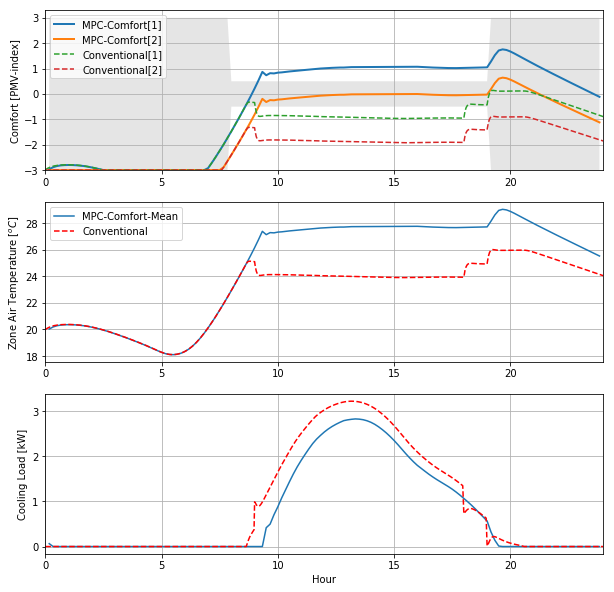

In [14]:
t_H=np.array(t_MPC)
Tz_H=np.array(Tz_MPC)
Qc_H=-np.array(Q_MPC)
PMV_H=np.vstack((np.array(PMV_MPC1),np.array(PMV_MPC2)))  
t_C=res_Conv['time']
Tz_C=res_Conv['y']
PMV_C=np.vstack((res_Conv['PMV[1]'],res_Conv['PMV[2]']))
Qc_C=-res_Conv['Q']

figure(figsize=(10,10))
ax=subplot(311)
ax.plot((t_H-start_time)/(3600),PMV_H.T,linewidth=2)
ax.plot((t_C-start_time)/(3600),PMV_C.T,'--')
YL=np.squeeze(np.array(H_schedule(t_H.T,[8,19],-0.5,-3)))
YU=np.squeeze(np.array(H_schedule(t_H.T,[8,19],0.5,3)))
ax.fill_between((t_H-start_time)/(3600),YL,YU,facecolor='grey',alpha=0.2)
ax.grid(True)
ax.set_ylabel('Comfort [PMV-index]')
ax.set_ylim(bottom=-3)
ax.set_xlim([0,24])
ax.legend(['MPC-Comfort[1]','MPC-Comfort[2]','Conventional[1]','Conventional[2]'],loc='best')

ax=subplot(312)
ax.plot((t_H-start_time)/(3600),Tz_H-273.15)
ax.plot((t_C-start_time)/(3600),Tz_C-273.15,'r--')
ax.set_xlim([0,24])
ax.grid(True)
ax.set_ylabel('Zone Air Temperature [$^oC$]')
ax.legend(['MPC-Comfort-Mean','Conventional'],loc='best')


ax=subplot(313)
ax.plot((t_H-start_time)/(3600),Qc_H/1e3)
ax.plot((t_C-start_time)/(3600),Qc_C/1e3,'r--')
ax.set_xlim([0,24])
ax.grid(True)
ax.set_ylabel('Cooling Load [kW]')
ax.set_xlabel('Hour')
savefig('MPC_mean.png')

Ec_C=np.trapz(Qc_C,t_C)
Ec_H=np.trapz(Qc_H.T,t_H.T)
print("Energy Cost Savings: ", (Ec_C-Ec_H)/Ec_C*100, '==============================')

#show(block=True)